# Metrics

## Notebook Aim 

- Devise metrics that can be dropped into analysis scripts
- Make plots of metrics with example data (e.g. color map to traces)

## Metric Aims

- Detect the really fucked up traces (e.g. scattering events)
    - Classify fucked up traces to mask them
- Quantify signal/noise

## Target Metrics

### Scattering

#### AUC

Will need correction for concentration I reckon

#### Average Gradient

Should be more negative if scattered

#### Scattering Curve Fit After Control Correction

More expensive, but more direct in terms of expected behaviour of scattered curves

---

## Data

- [ ] Gather dataset of bad traces 

In [1]:
import os
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import utils

root_dir_walk = os.walk('..')

experiments = {}

for dirpath, dirnames, filenames in root_dir_walk:
    if (e := re.search('\.\./([0-9]+)', dirpath)) is not None:
        experiment_number = int(e.group(1))
        if 1 <= experiment_number <= 22:
            data = {}

            for fname in filenames:
                fpath = os.path.join(dirpath, fname)
                if re.search('experiment-[0-9]+-summary\.csv', fname) is not None:
                    data['summary_fname'] = fname 
                    data['summary_path'] = fpath
                    #data['summary'] = pd.read_csv(fpath, index_col=0)
                if re.search('config_[0-9]+\.json', fname) is not None:
                    data['config_fname'] = fname 
                    with open(fpath, 'r') as f:
                        data['config'] = json.load(f)
            if data != {}:
                experiments[experiment_number] = data

df = pd.concat([pd.read_csv(experiments[i]['summary_path']) for i in experiments]).reset_index(drop=True)
df.head()

ligand          km      vmax       rsq  column_num  \
0                NaN    1.538950  0.012510  0.021696         1.0   
1  Arachadionic Acid  285.406633  0.079279 -2.393192         2.0   
2  Arachadionic Acid  337.546311  0.083692 -2.341006         3.0   
3  Arachadionic Acid  261.523179  0.082059 -2.433887         4.0   
4  Arachadionic Acid  265.911556  0.077865 -2.452384         5.0   

   protein_concentration  a420_max   auc_mean    auc_cv   std_405  ...  \
0                   4.01     0.093   8.606125  0.575958  0.008799  ...   
1                   4.01     0.080  10.597500  0.443524  0.012873  ...   
2                   4.01     0.083   8.540825  0.461805  0.005500  ...   
3                   4.01     0.082   8.798688  0.503424  0.005182  ...   
4                   4.01     0.081   8.220812  0.391866  0.005153  ...   

   shaking_seconds  BSA protein_conc protein_vol  Unnamed: 0  \
0              NaN  NaN          NaN         NaN         NaN   
1              NaN  NaN          NaN         NaN         NaN   
2              NaN  NaN          NaN         NaN         NaN   
3              NaN  NaN          NaN         NaN         NaN   
4              NaN  NaN          NaN         NaN         NaN   

   ligand_dispensing  bulk_dispensing  protein_volume experiments  column  
0                NaN              NaN             NaN         NaN     NaN  
1                NaN              NaN             NaN         NaN     NaN  
2                NaN              NaN             NaN         NaN     NaN  
3                NaN              NaN             NaN         NaN     NaN  
4                NaN              NaN             NaN         NaN     NaN  

[5 rows x 49 columns]

In [2]:
 with open('../bad-traces.txt', 'r') as f:
    bad_traces = f.read().splitlines()

bad_traces

['./5_More_Iterations/img/5-None-plate_1-column-1-ligand-None.png',
 './5_More_Iterations/img/5-None-plate_1-column-2-ligand-Arachadionic Acid.png',
 './16_Echo/img/plate_1-block-13-ligand-None.png',
 './16_Echo/img/plate_1-block-1-ligand-None.png',
 './16_Echo/img/plate_1-block-7-ligand-None.png',
 './16_Echo/img/plate_2-block-1-ligand-None.png',
 './16_Echo/img/plate_2-block-3-ligand-None.png',
 './16_Echo/img/plate_2-block-7-ligand-None.png',
 './16_Echo/img/plate_3-block-5-ligand-None.png',
 './16_Echo/img/plate_3-block-7-ligand-None.png',
 './16_Echo/img/plate_4-block-13-ligand-None.png',
 './16_Echo/img/plate_4-block-7-ligand-None.png',
 './7_Moreiterations/img/7-None-plate_3-column-2-ligand-Arachadionic Acid.png',
 './7_Moreiterations/img/7-None-plate_4-column-2-ligand-Arachadionic Acid.png',
 './14_DMSO_dilutionScheme/img/14-None-plate_1-column-12-ligand-SDS.png',
 './19_Validation/img/plate_3-block-18-ligand-Palmitic acid.png',
 './19_Validation/img/plate_3-block-2-ligand-Laur

In [3]:
s = bad_traces[0]

def get_trace_info(path):
    search = lambda p, s : match.group(1) if (match := re.match(p, s)) else None
    root = path.split('/')[1]
    experiment_number = int(search('\./([0-9]+)', path))
    plate = search('.*(plate_[0-9]+)', path) or search('.*img/([0-9]+)', path) 
    column = search('.*column-([0-9]+)', path) or search('.*block-([0-9]+)', path)
    
    config = experiments[experiment_number]['config']
    file_name =  config['experiments'][plate]['file']
    file_path = os.path.join('..', root, file_name)

    test_wells = None
    control_wells = None
    
    if (blocks := config.get('blocks')):
        if (block := blocks.get(str(column))):
            test_wells = block.get('test_wells') 
            control_wells = block.get('control_wells') 
    else:
        if (test_rows := config.get('test_rows')):
            test_wells = [f'{i}{j}' for i, j in zip(test_rows, range(1,9))]
        if (control_rows := config.get('control_rows') ):
            control_wells = [f'{i}{j}' for i, j in zip(control_rows, range(1,9))]

    # experiment 18 edge case ffs
    if test_wells is None:
        if (blocks_kinda := config.get('experiments')):
            if (blocks := blocks_kinda[plate]['blocks']):
                if (block := blocks.get(str(column))):
                    test_wells = block.get('test_wells') 
                    control_wells = block.get('control_wells') 
                    # experiments[18]['config']['experiments']['1']['blocks']['1']['test_wells']

    return {
        'experiment_number': experiment_number,
        'root': root,
        'plate': plate,
        'column': column,
        'file_path': file_path,
        'test_wells': test_wells,
        'control_wells': control_wells,
    }

bad_trace_data = pd.DataFrame((map(get_trace_info, bad_traces)))
bad_trace_data

experiment_number                         root    plate column  \
0                   5            5_More_Iterations  plate_1      1   
1                   5            5_More_Iterations  plate_1      2   
2                  16                      16_Echo  plate_1     13   
3                  16                      16_Echo  plate_1      1   
4                  16                      16_Echo  plate_1      7   
5                  16                      16_Echo  plate_2      1   
6                  16                      16_Echo  plate_2      3   
7                  16                      16_Echo  plate_2      7   
8                  16                      16_Echo  plate_3      5   
9                  16                      16_Echo  plate_3      7   
10                 16                      16_Echo  plate_4     13   
11                 16                      16_Echo  plate_4      7   
12                  7             7_Moreiterations  plate_3      2   
13                  7             7_Moreiterations  plate_4      2   
14                 14       14_DMSO_dilutionScheme  plate_1     12   
15                 19                19_Validation  plate_3     18   
16                 19                19_Validation  plate_3      2   
17                 19                19_Validation  plate_3      3   
18                 19                19_Validation  plate_3      4   
19                 19                19_Validation  plate_3      5   
20                 19                19_Validation  plate_3      6   
21                 19                19_Validation  plate_3      7   
22                 19                19_Validation  plate_7     10   
23                 18         18_BuffersNCompounds        1     12   
24                 18         18_BuffersNCompounds        1     15   
25                 18         18_BuffersNCompounds        1     17   
26                 18         18_BuffersNCompounds        1     19   
27                 18         18_BuffersNCompounds        2     12   
28                 18         18_BuffersNCompounds        2     19   
29                 18         18_BuffersNCompounds        3      1   
30                 18         18_BuffersNCompounds        3      3   
31                 18         18_BuffersNCompounds        3      4   
32                 18         18_BuffersNCompounds        4      1   
33                 18         18_BuffersNCompounds        4      3   
34                 15                      15_Echo  plate_3      4   
35                 13  13_TitrationValidationPilot  plate_2      4   
36                 22               22_validation2  plate_1     11   

                                            file_path  \
0               ../5_More_Iterations/20190619_boi.CSV   
1               ../5_More_Iterations/20190619_boi.CSV   
2                   ../16_Echo/data/20191104_Dopt.CSV   
3                   ../16_Echo/data/20191104_Dopt.CSV   
4                   ../16_Echo/data/20191104_Dopt.CSV   
5                 ../16_Echo/data/20191105_Dopt_2.CSV   
6                 ../16_Echo/data/20191105_Dopt_2.CSV   
7                 ../16_Echo/data/20191105_Dopt_2.CSV   
8    ../16_Echo/data/20191105_Dopt_2_Shaking_rep2.CSV   
9    ../16_Echo/data/20191105_Dopt_2_Shaking_rep2.CSV   
10                  ../16_Echo/data/20191104_Dopt.CSV   
11                  ../16_Echo/data/20191104_Dopt.CSV   
12  ../7_Moreiterations/20190625_regularplate_boi.CSV   
13  ../7_Moreiterations/20190625_regularplate_boi2...   
14        ../14_DMSO_dilutionScheme/data/20191018.CSV   
15  ../19_Validation/PlateData/Attempt1/20191127_N...   
16  ../19_Validation/PlateData/Attempt1/20191127_N...   
17  ../19_Validation/PlateData/Attempt1/20191127_N...   
18  ../19_Validation/PlateData/Attempt1/20191127_N...   
19  ../19_Validation/PlateData/Attempt1/20191127_N...   
20  ../19_Validation/PlateData/Attempt1/20191127_N...   
21  ../19_Validation/PlateData/Attempt1/20191127_N...   
22  ../19_Validation/PlateData/A

## Raw Data

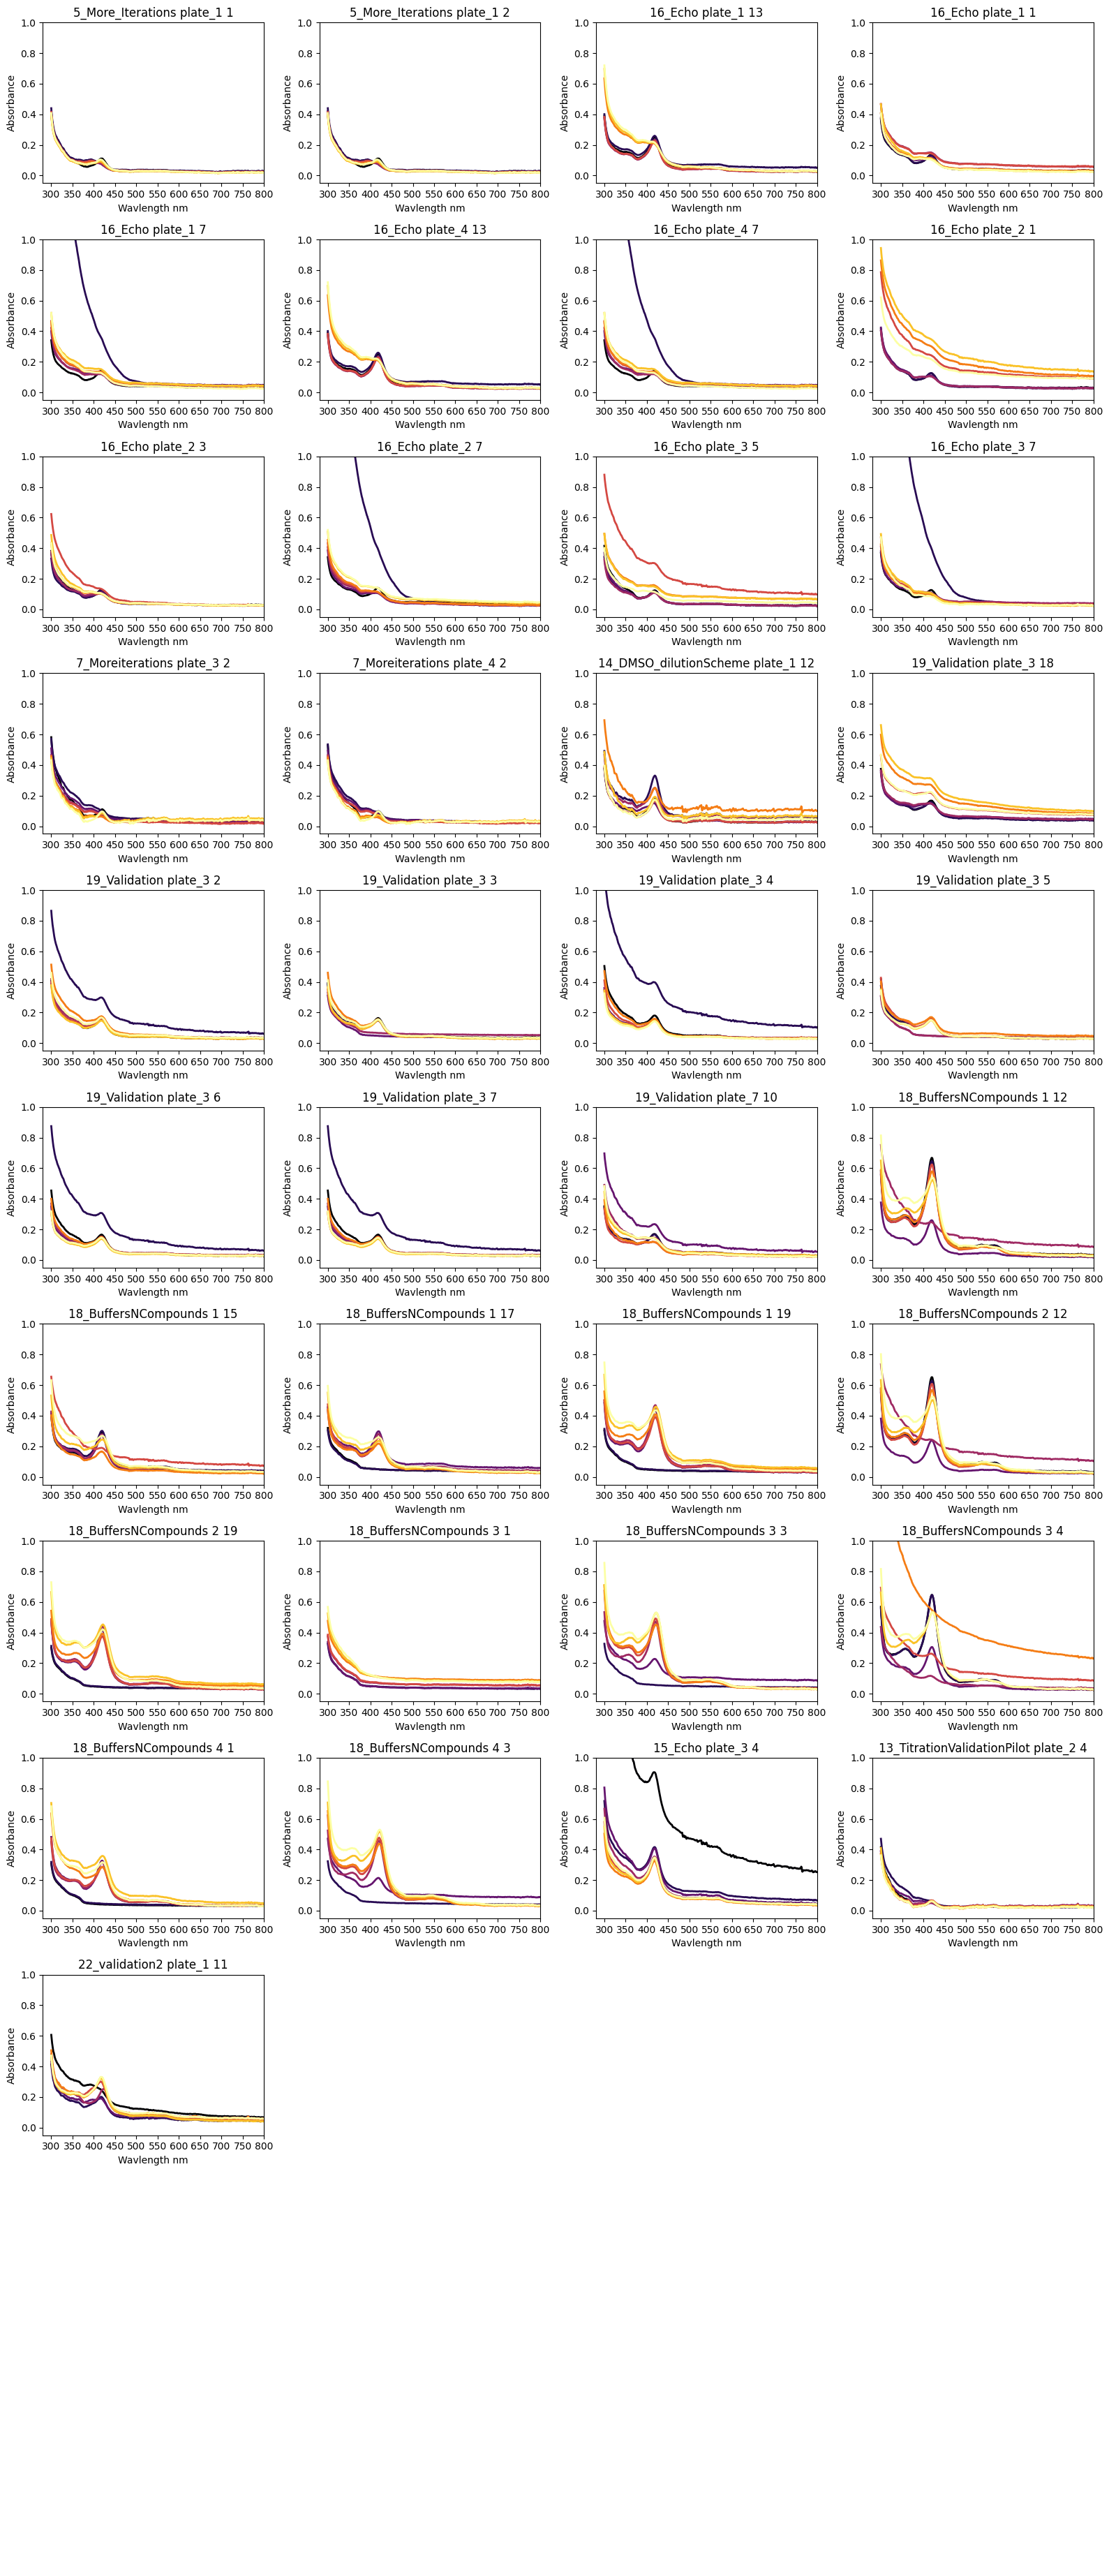

In [22]:
n_plots = len(bad_trace_data)
fig, axs = plt.subplots(n_plots // 3,
                        4,
                        figsize=(16, len(bad_trace_data)),
                       )

get_ax = iter(axs.flatten())

for path in bad_trace_data['file_path'].unique():
    df = utils.bmg.parse_bmg(path).loc[:, 300:]
    chunk = bad_trace_data.loc[bad_trace_data['file_path'] == path, :]
    for idx, row in chunk.iterrows():
        test_wells = df.loc[row['test_wells'], :]
        control_wells = df.loc[row['control_wells'], :]
        utils.plot.plot_plate_data(test_wells,
                                   title= ' '.join([row['root'], row['plate'], row['column']]),
                                   ax=next(get_ax),
                                  )
for ax in get_ax:
    ax.axis('off')
plt.tight_layout()
plt.show()

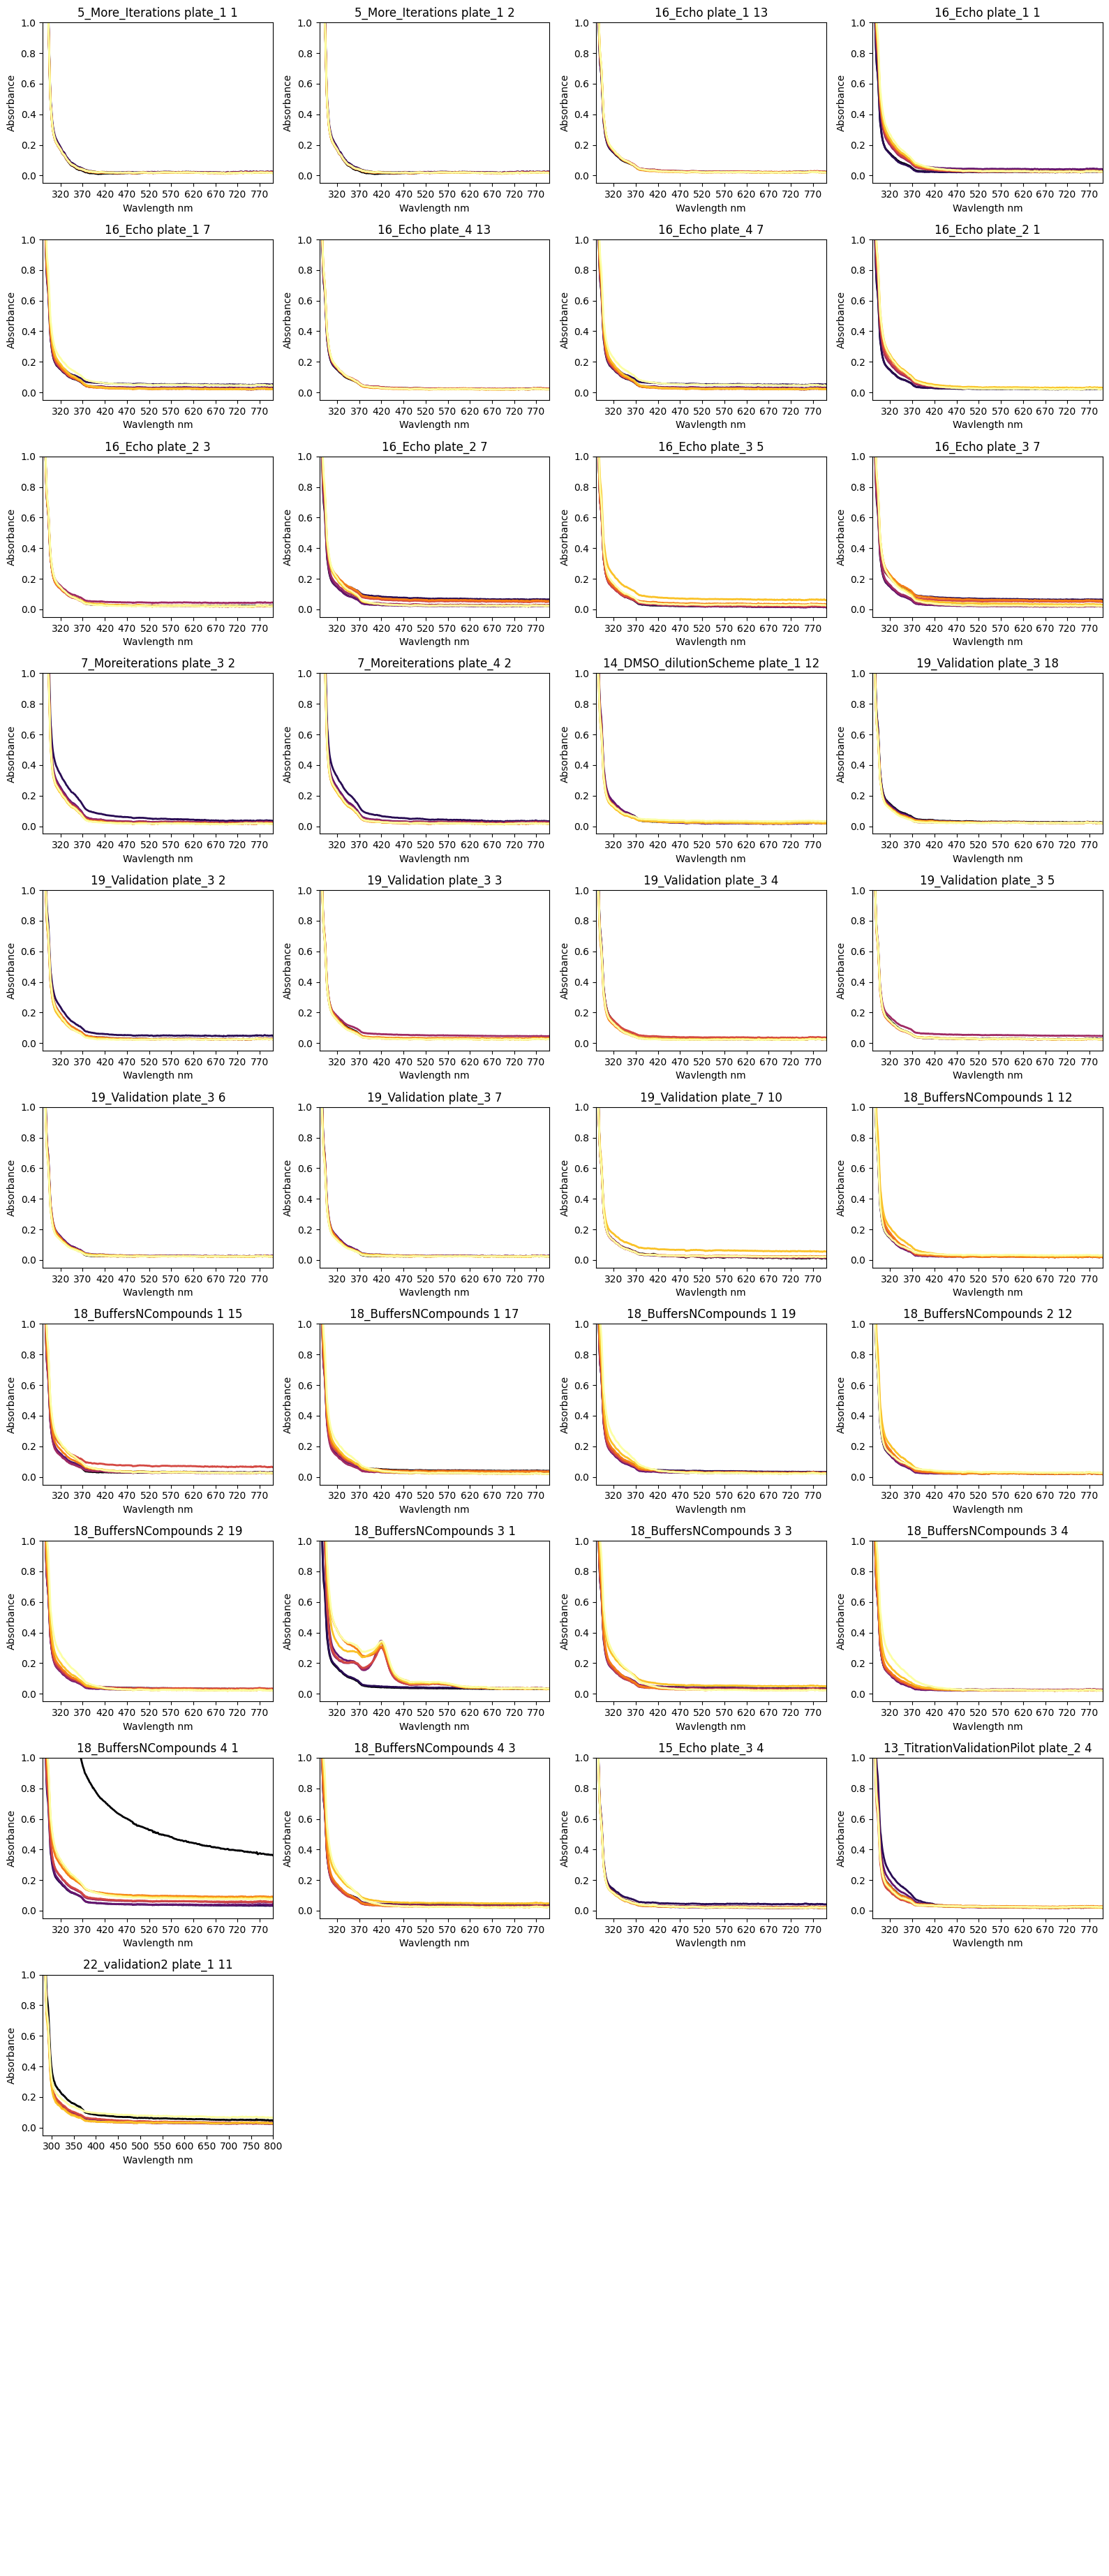

In [23]:
n_plots = len(bad_trace_data)
fig, axs = plt.subplots(n_plots // 3,
                        4,
                        figsize=(16, len(bad_trace_data)),
                       )

get_ax = iter(axs.flatten())

all_controls = []
all_tests = []

for path in bad_trace_data['file_path'].unique():
    df = utils.bmg.parse_bmg(path)
    chunk = bad_trace_data.loc[bad_trace_data['file_path'] == path, :]
    for idx, row in chunk.iterrows():
        test_wells = df.loc[row['test_wells'], :]
        control_wells = df.loc[row['control_wells'], :]
        utils.plot.plot_plate_data(control_wells,
                                   title= ' '.join([row['root'], row['plate'], row['column']]),
                                   ax=next(get_ax),
                                  )
        all_controls.append(control_wells)
        all_tests.append(test_wells)
        
all_tests = pd.concat(all_tests).dropna()
all_controls = pd.concat(all_controls).dropna()

for ax in get_ax:
    ax.axis('off')
plt.tight_layout()
plt.show()

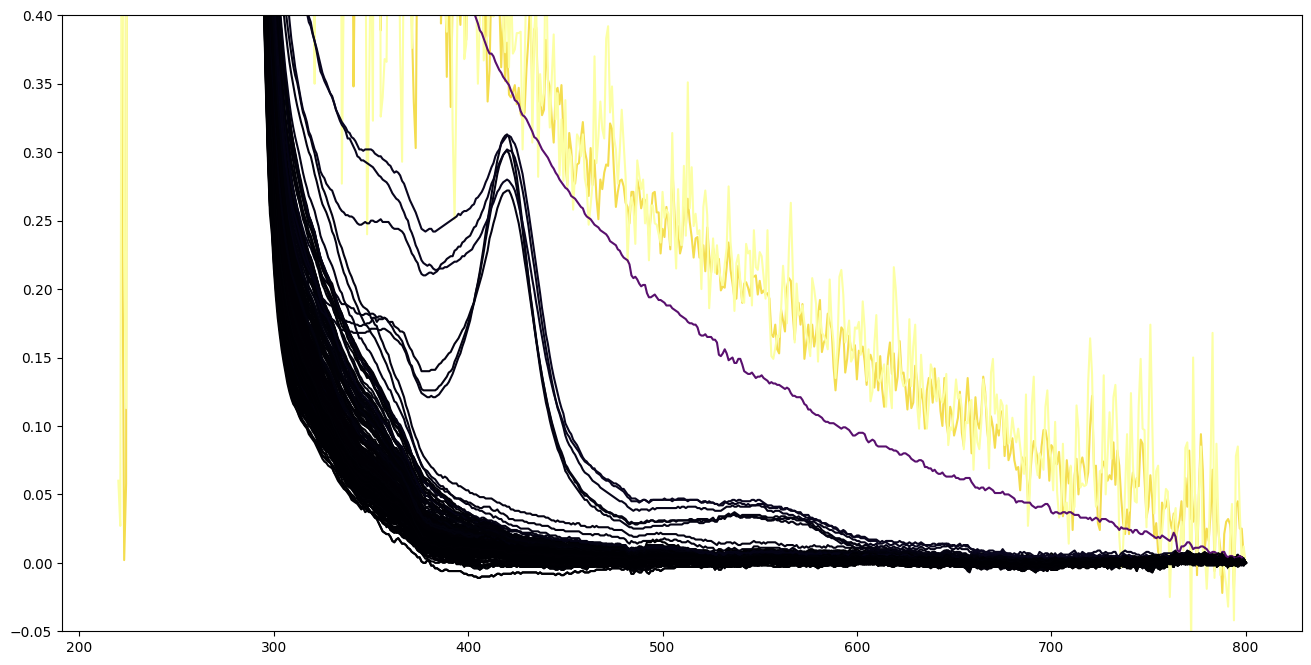

In [24]:
from matplotlib.cm import inferno
from sklearn.decomposition import  PCA

pca = PCA(n_components=1)
decomp = pca.fit_transform(all_controls)[:, 0]
decomp -= min(decomp)
decomp /= max(decomp)

plt.figure(figsize=(16, 8))
for i in range(len(all_controls)):
    row = all_controls.iloc[i, :]
    row -= row[800]
    plt.plot(row,
             c=inferno(decomp[i]),
            )
plt.ylim(-0.05, 0.4)
plt.show()

In [25]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN()
clusters = clusterer.fit_predict(all_controls)
clusters

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

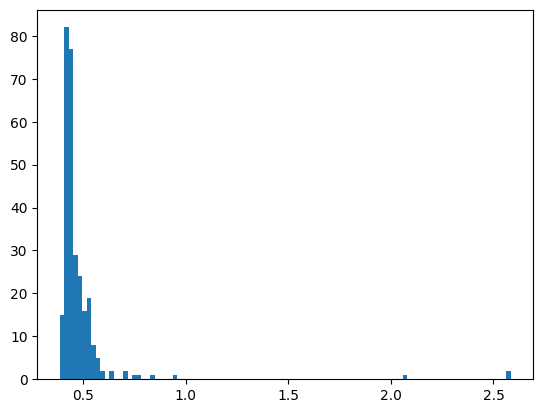

In [26]:
plt.hist(all_tests.mean(axis=1),
        bins=100)
plt.show()

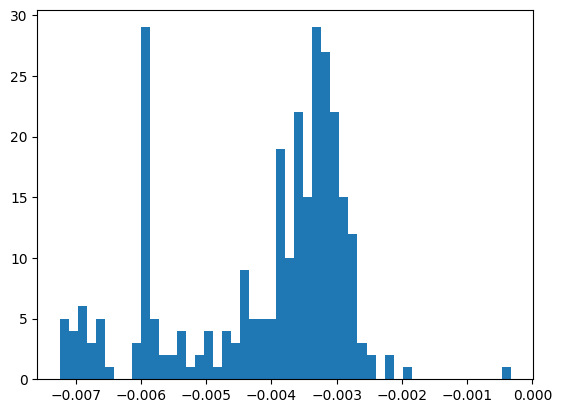

In [27]:
plt.hist(np.gradient(all_tests, axis=1).mean(axis=1), bins=50)
plt.show()

In [28]:
def plot_plate_data_(data,
                    title=None,
                    ligand_name=None,
                    save_path=None,
                    cmap=None,
                    cmap_name=None,
                    ax=None,
                    ylim=None,
                    legend_text=None,
                    ):
    x = data.columns.astype(int)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,5))

    if cmap is not None:
        # colors = plt.cm.inferno((concs - min(concs))/max(concs))
        _cmap = (cmap - cmap.min()) 
        _cmap /= _cmap.max()
        colors = plt.cm.inferno(_cmap)
        # if concs.argmax() == 0:
        #     colors = plt.cm.inferno(np.linspace(1, 0, len(data)))
        # else:
        #     colors = plt.cm.inferno(np.linspace(0, 1, len(data)))
    else:
        colors = plt.cm.inferno(np.linspace(0, 1, len(data)))

    for i, j in enumerate(data.index):
        y = data.loc[j,:]
        ax.plot(x,
                y, 
                lw=2, 
                color=colors[i],
                label=round(cmap[i], 2) if cmap is not None else y.index,
                )
    if title is not None:
        ax.set_title(title)

    if ylim is None:
        ax.set_ylim((-0.05,1))
    else:
        ax.set_ylim(ylim)


    ax.set_xticks(x[::50])
    ax.set_xlim((280,800))
    ax.set_xlabel('Wavlength nm')
    ax.set_ylabel('Absorbance')

    if cmap is not None:
        if ligand_name is not None:
            if legend_text is not None:
                handles, labels = ax.get_legend_handles_labels()
                handles.append(mpatches.Patch(color='none', label=legend_text))
            else:
                handles = None
            ax.legend([round(i, 2) for i in cmap], 
                      title = f'{ligand_name} concentration μM',
                      loc='right',
                      handles=handles,
                      )
        else:
            ax.legend([round(i, 2) for i in cmap], 
                      title=cmap_name or 'Concentration μM',
                      loc='right',
                      )
    if ax is None and save_path is not None:
        assert 'fig' in locals()
        fig.savefig(save_path)


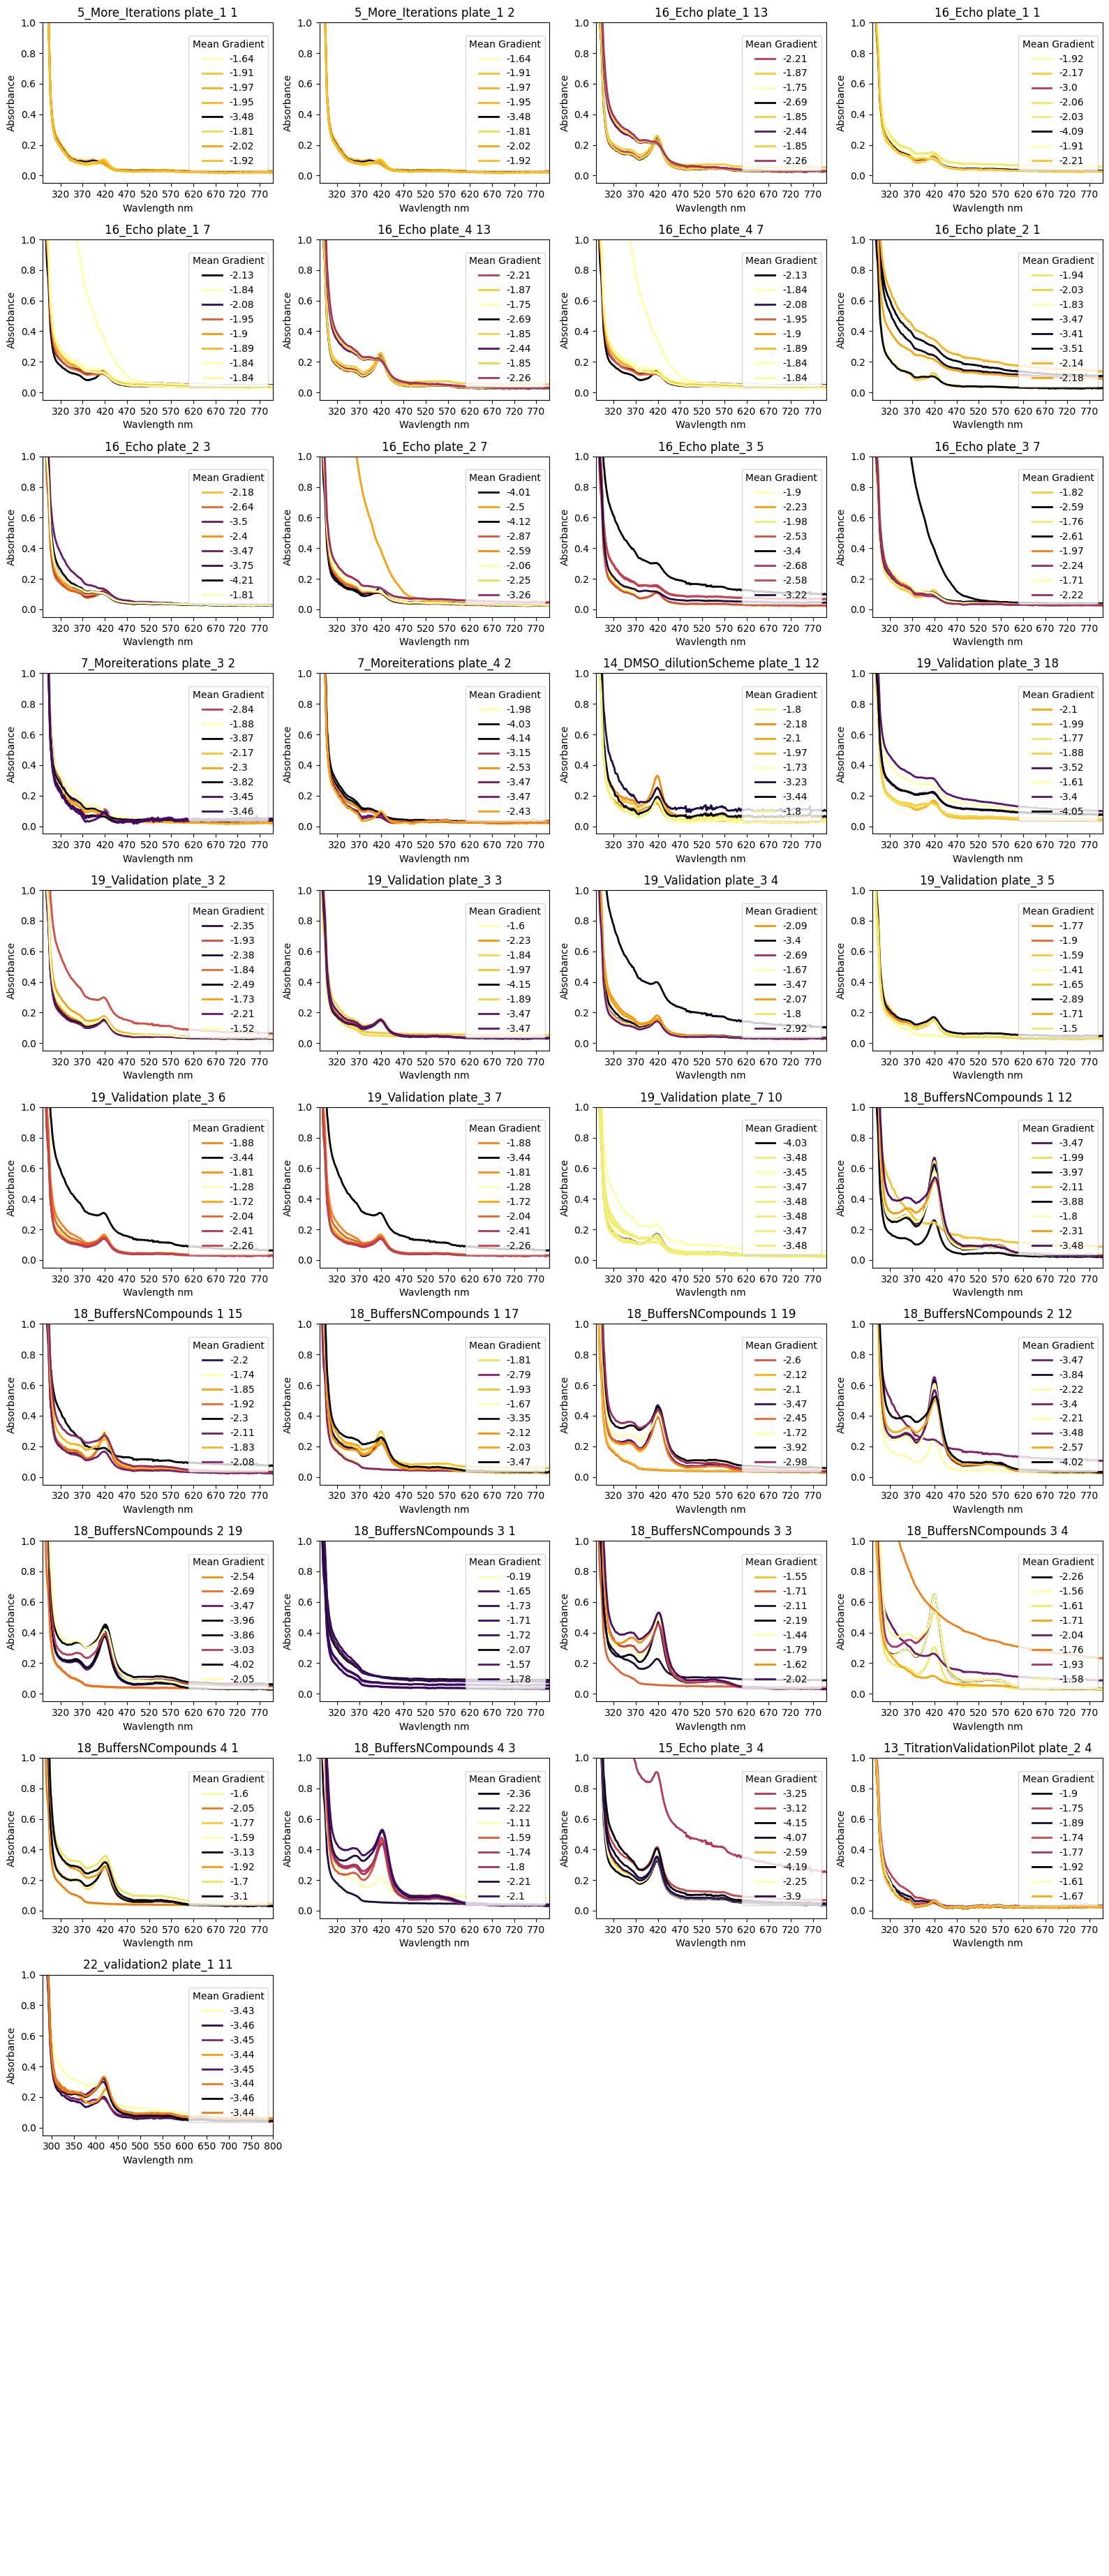

In [29]:
n_plots = len(bad_trace_data)
fig, axs = plt.subplots(n_plots // 3,
                        4,
                        figsize=(16, len(bad_trace_data)),
                       )

get_ax = iter(axs.flatten())

for path in bad_trace_data['file_path'].unique():
    df = utils.bmg.parse_bmg(path)
    chunk = bad_trace_data.loc[bad_trace_data['file_path'] == path, :]
    for idx, row in chunk.iterrows():
        test_wells = df.loc[row['test_wells'], :]
        gradients = np.gradient(test_wells, axis=1).sum(axis=1)
        control_wells = df.loc[row['control_wells'], :]
        plot_plate_data_(test_wells,
                         title= ' '.join([row['root'], row['plate'], row['column']]),
                         ax=next(get_ax),
                         cmap=gradients,
                         cmap_name='Mean Gradient',
                         )
for ax in get_ax:
    ax.axis('off')
plt.tight_layout()
plt.show()

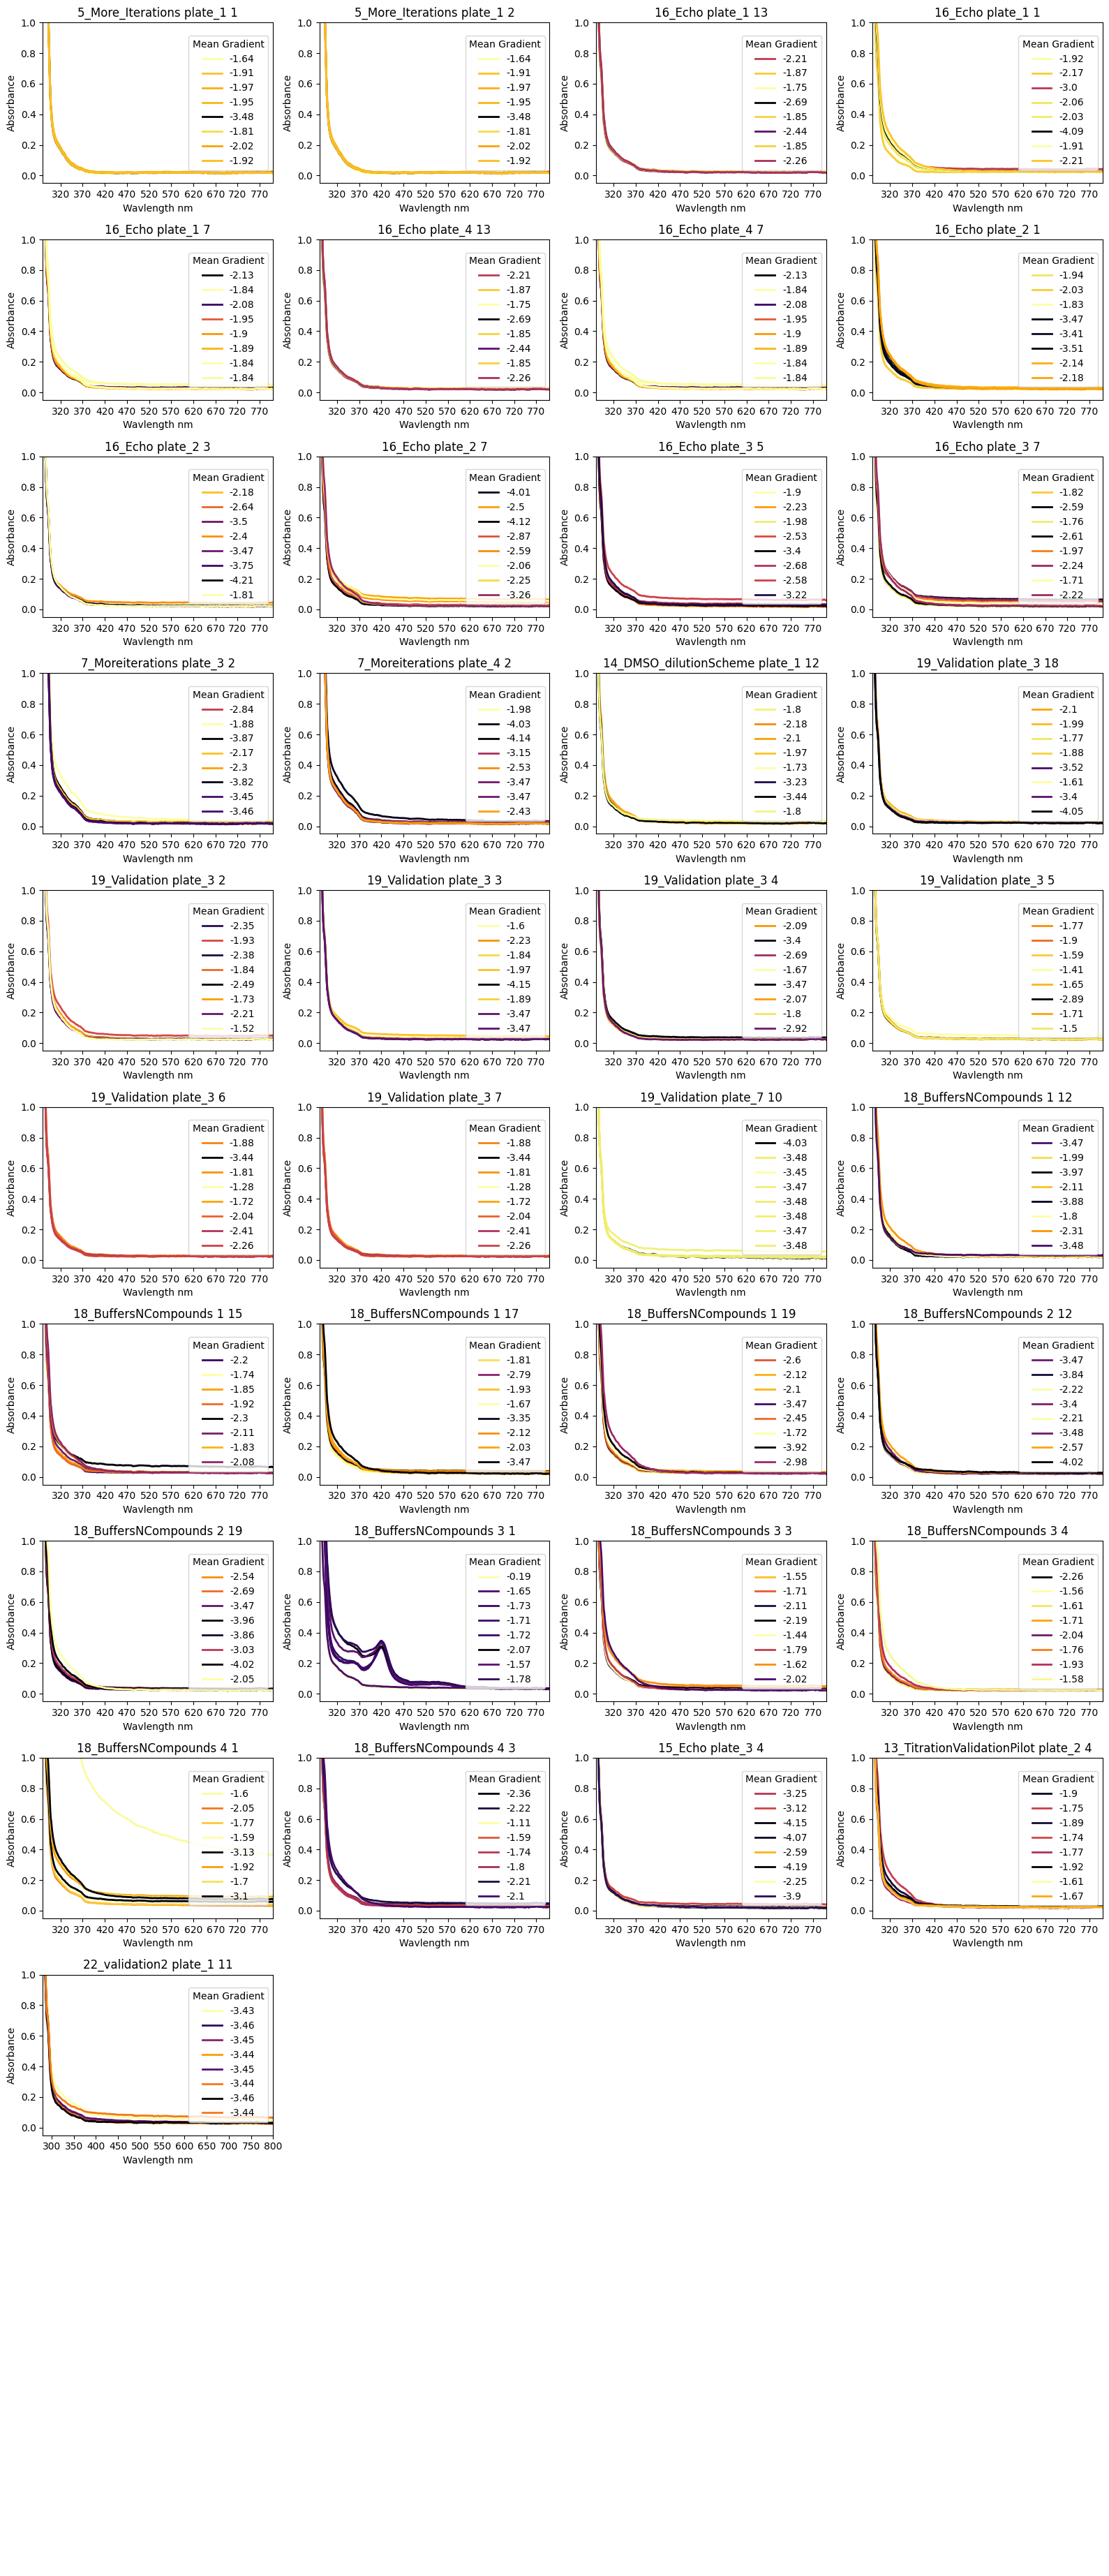

In [30]:
n_plots = len(bad_trace_data)
fig, axs = plt.subplots(n_plots // 3,
                        4,
                        figsize=(16, len(bad_trace_data)),
                       )

get_ax = iter(axs.flatten())

for path in bad_trace_data['file_path'].unique():
    df = utils.bmg.parse_bmg(path)
    chunk = bad_trace_data.loc[bad_trace_data['file_path'] == path, :]
    for idx, row in chunk.iterrows():
        test_wells = df.loc[row['test_wells'], :]
        gradients = np.gradient(test_wells, axis=1).sum(axis=1)
        control_wells = df.loc[row['control_wells'], :]
        plot_plate_data_(control_wells,
                         title= ' '.join([row['root'], row['plate'], row['column']]),
                         ax=next(get_ax),
                         cmap=gradients,
                         cmap_name='Mean Gradient',
                         )
for ax in get_ax:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [37]:
all_controls.sum(axis=1)

B1    217.633
D2    220.914
F3    228.109
H4    230.447
J5    230.412
       ...   
H4    215.689
J5    214.297
L6    223.007
N7    218.837
P8    221.661
Length: 288, dtype: float64

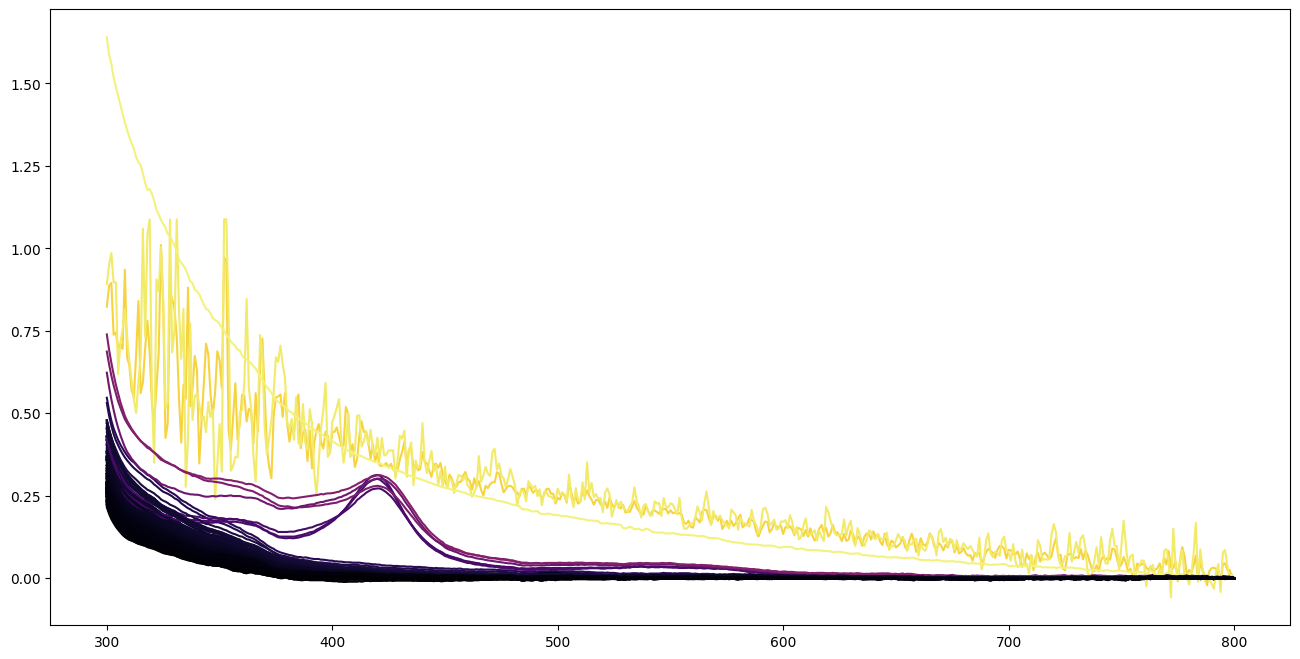

In [103]:
plt.figure(figsize=(16,8))

all_controls = all_controls.loc[:, 300:]
all_controls_minsum = min(all_controls.sum(axis=1))
all_controls_maxsum = max(all_controls.sum(axis=1))

def color_area(row):
    return inferno((row.sum() - all_controls_minsum) / all_controls_maxsum)
    

for i in range(len(all_controls)):
    row = all_controls.iloc[i, :]
    plt.plot(row, c=color_area(row))
plt.show()

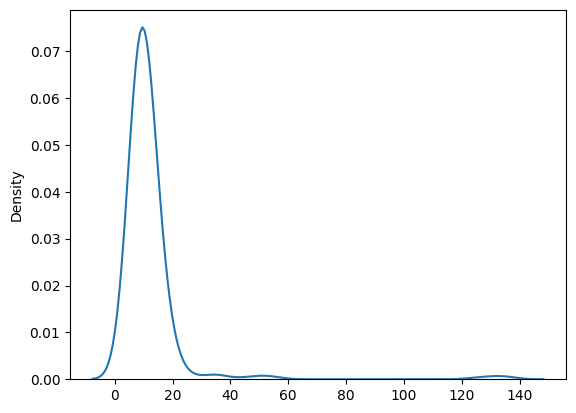

In [49]:
import seaborn as sns
sns.kdeplot(all_controls.sum(axis=1))
plt.show()

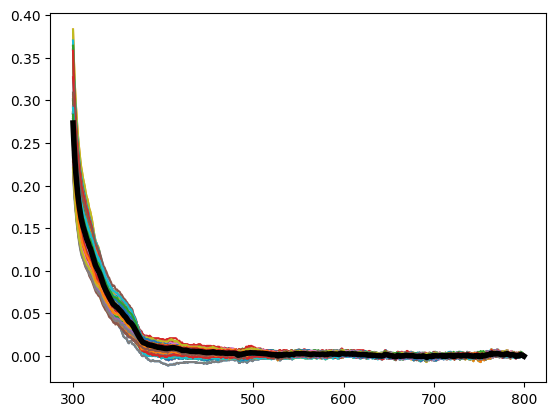

In [63]:
baseline_traces = all_controls.loc[all_controls.sum(axis=1) < 10, :]
for i in range(len(baseline_traces)):
    plt.plot(baseline_traces.iloc[i, :])
plt.plot(baseline_traces.mean(axis=0),
        lw=4,
        label='mean',
         color='black',
        )

plt.show()

array([ 2.63681157e-01,  2.50312956e-01,  2.32879254e-01,  2.17309287e-01,
        2.04260804e-01,  1.93131128e-01,  1.83535854e-01,  1.75242776e-01,
        1.68068735e-01,  1.61949824e-01,  1.56853634e-01,  1.52569871e-01,
        1.48787863e-01,  1.45141986e-01,  1.41494037e-01,  1.38064444e-01,
        1.34987924e-01,  1.32039523e-01,  1.29115559e-01,  1.26334550e-01,
        1.23424184e-01,  1.20299441e-01,  1.16969308e-01,  1.13378713e-01,
        1.09802708e-01,  1.06679417e-01,  1.04138552e-01,  1.01958700e-01,
        9.98967623e-02,  9.77025541e-02,  9.51697411e-02,  9.23147620e-02,
        8.92185342e-02,  8.60605120e-02,  8.31363707e-02,  8.05246100e-02,
        7.81026911e-02,  7.58449052e-02,  7.37138124e-02,  7.16138882e-02,
        6.95629843e-02,  6.75823110e-02,  6.56809113e-02,  6.38454753e-02,
        6.21265621e-02,  6.07503949e-02,  5.97105729e-02,  5.87594411e-02,
        5.78667317e-02,  5.70079535e-02,  5.60445429e-02,  5.49809174e-02,
        5.38604186e-02,  

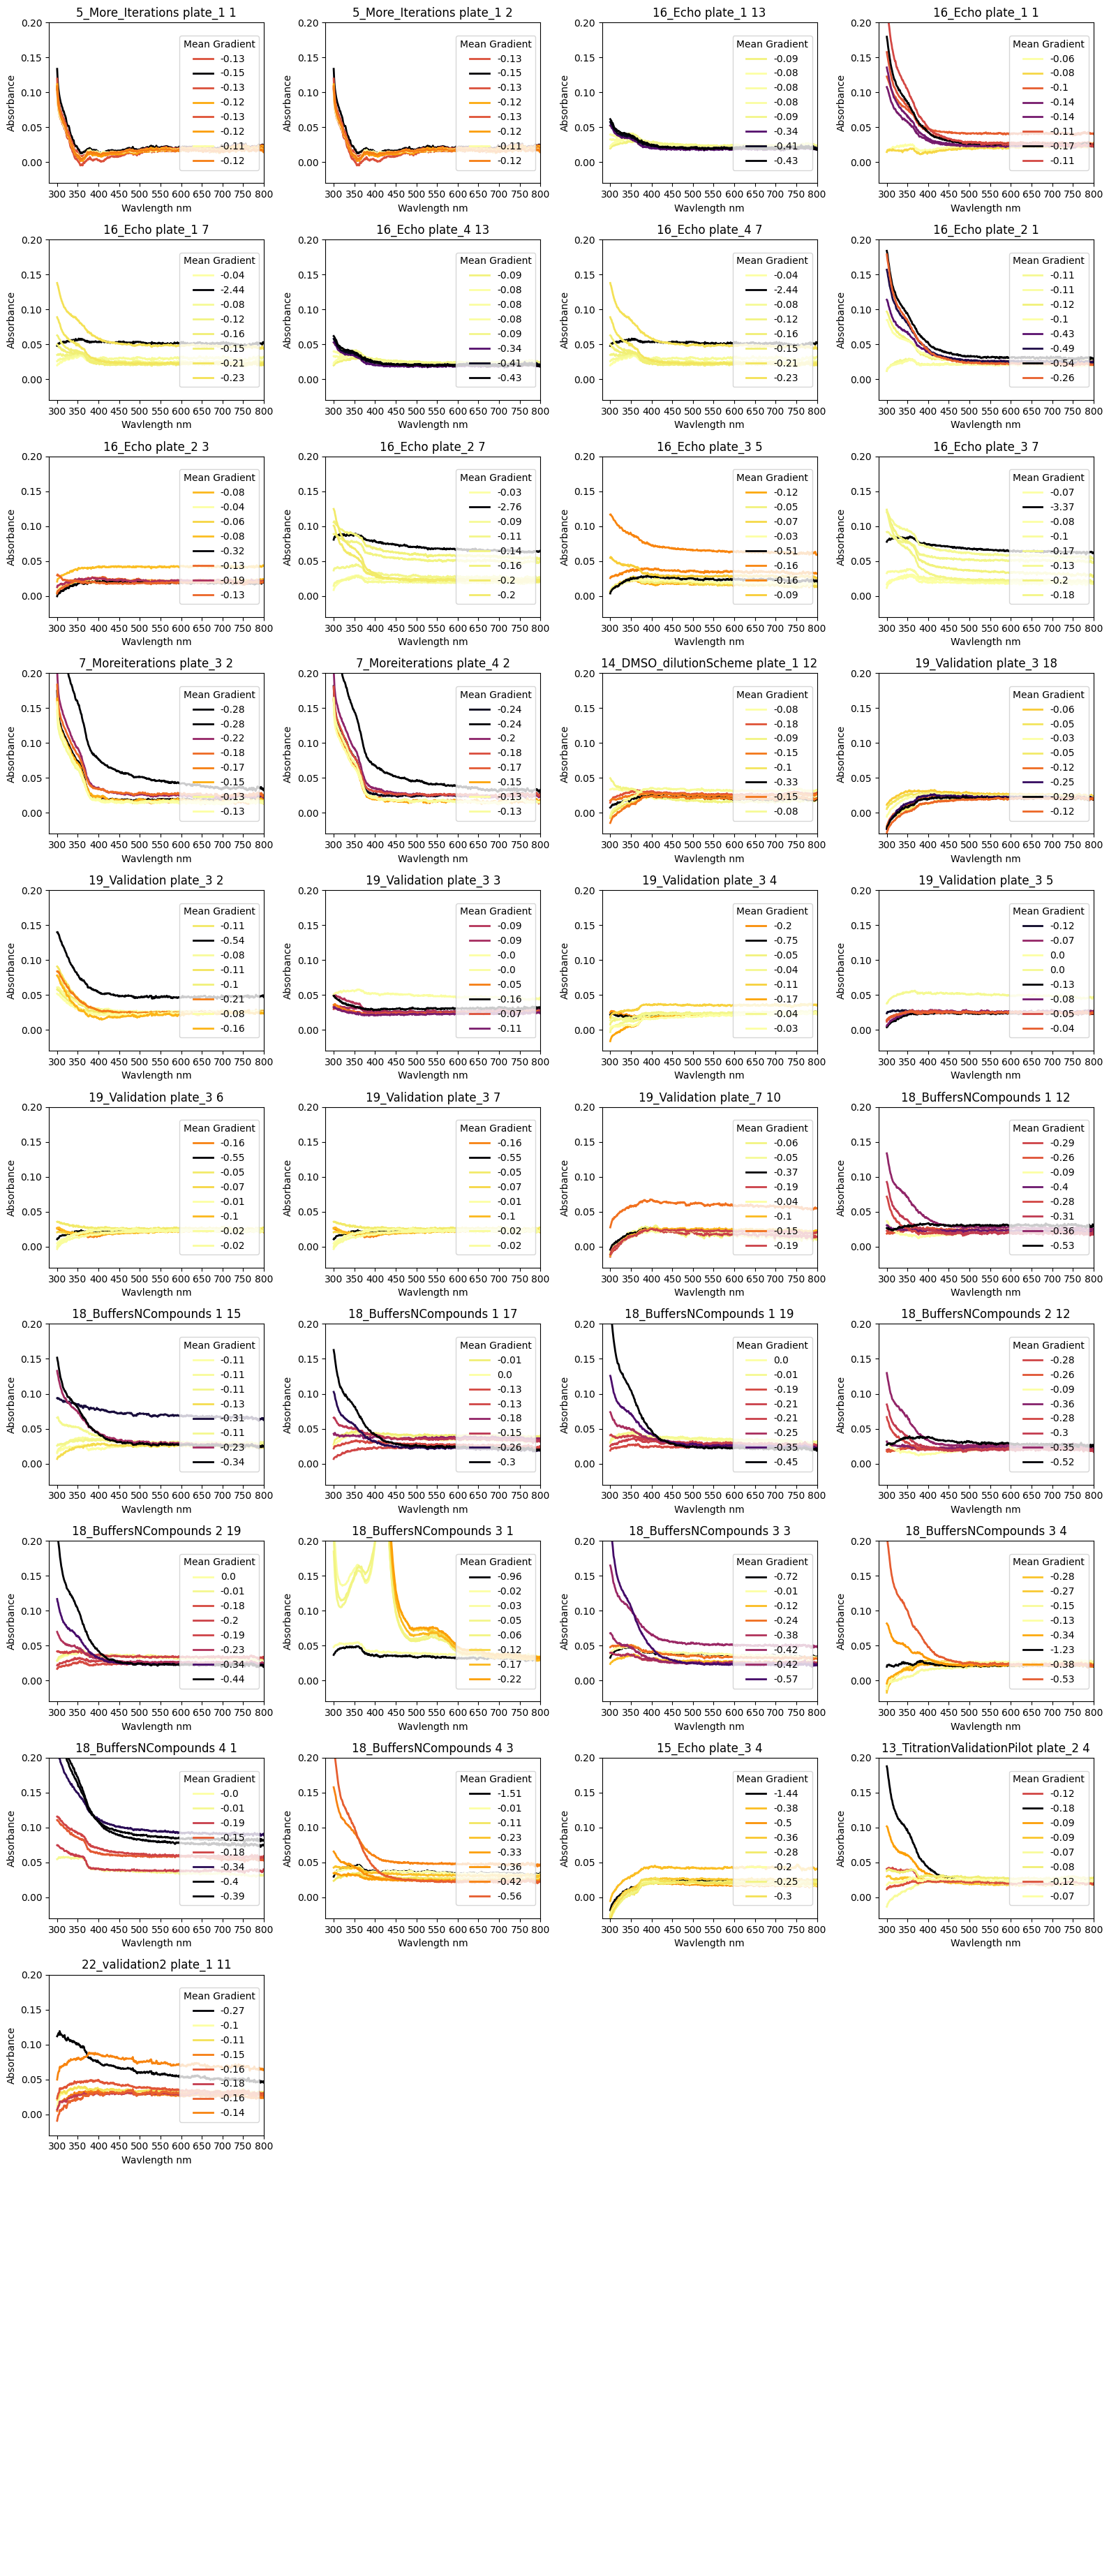

In [85]:
n_plots = len(bad_trace_data)
fig, axs = plt.subplots(n_plots // 3,
                        4,
                        figsize=(16, len(bad_trace_data)),
                       )

get_ax = iter(axs.flatten())

x = baseline_traces.mean(axis=0)

for path in bad_trace_data['file_path'].unique():
    df = utils.bmg.parse_bmg(path)
    chunk = bad_trace_data.loc[bad_trace_data['file_path'] == path, :]
    df = df.loc[:, 300:]
    for idx, row in chunk.iterrows():
        test_wells = df.loc[row['test_wells'], :]
        test_wells = test_wells - x
        control_wells = df.loc[row['control_wells'], :]
        control_wells = control_wells - x
        gradients = np.gradient(test_wells, axis=1).sum(axis=1)
        plot_plate_data_(control_wells,
                         title= ' '.join([row['root'], row['plate'], row['column']]),
                         ax=next(get_ax),
                         cmap=gradients,
                         cmap_name='Mean Gradient',
                         ylim=(-0.03, 0.2),
                         )
for ax in get_ax:
    ax.axis('off')
plt.tight_layout()
plt.show()

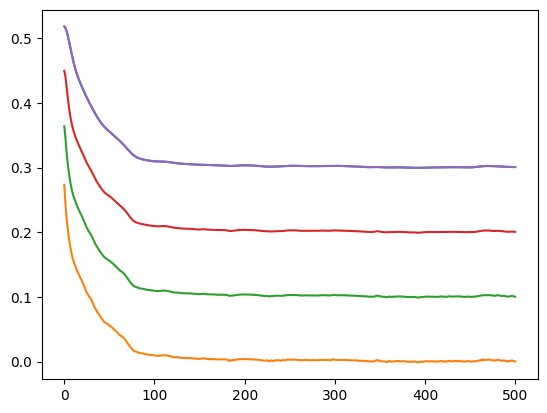

In [110]:
from scipy import ndimage

x = baseline_traces.mean(axis=0)
xs5 = pd.Series(ndimage.gaussian_filter1d(x, sigma=5),
                index=x.index)

plt.plot(ndimage.gaussian_filter1d(x, sigma=5) + 0.3)

plt.plot(x.values)
plt.plot(ndimage.gaussian_filter1d(x, sigma=1) + 0.1)
plt.plot(ndimage.gaussian_filter1d(x, sigma=2) + 0.2)
plt.plot(ndimage.gaussian_filter1d(x, sigma=5) + 0.3)
plt.show()

0      300    301    302    303    304    305    306    307    308    309  \
A1   0.393  0.355  0.327  0.306  0.288  0.272  0.258  0.247  0.236  0.228   
B1   0.359  0.322  0.297  0.276  0.259  0.244  0.231  0.220  0.210  0.202   
C1   0.390  0.353  0.324  0.303  0.285  0.268  0.255  0.244  0.233  0.224   
D1   0.356  0.320  0.294  0.272  0.256  0.242  0.228  0.217  0.208  0.200   
E1   0.387  0.349  0.321  0.299  0.281  0.266  0.252  0.240  0.229  0.220   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
P20  0.220  0.200  0.185  0.172  0.162  0.152  0.148  0.140  0.133  0.127   
P21  0.220  0.201  0.186  0.173  0.163  0.154  0.150  0.143  0.136  0.130   
P22  0.236  0.217  0.201  0.188  0.177  0.168  0.164  0.156  0.149  0.143   
P23  0.256  0.235  0.219  0.205  0.194  0.184  0.179  0.171  0.164  0.157   
P24  0.288  0.268  0.252  0.237  0.225  0.215  0.210  0.201  0.194  0.187   

0    ...    791    792    793    794    795    796    797    798    799  800  
A1   ...  0.002  0.001  0.001  0.002  0.002  0.002  0.003  0.002  0.000  0.0  
B1   ...  0.000  0.001  0.000  0.002  0.003  0.002  0.003  0.002  0.000  0.0  
C1   ...  0.001  0.001  0.001  0.001  0.002  0.002  0.004  0.002  0.000  0.0  
D1   ... -0.001 -0.001 -0.001  0.000  0.001  0.001  0.003  0.001 -0.001  0.0  
E1   ...  0.000  0.000  0.000  0.001  0.002  0.002  0.003  0.002 -0.001  0.0  
..   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...  
P20  ...  0.001  0.001  0.001  0.002  0.002  0.002  0.001  0.002  0.001  0.0  
P21  ...  0.000 -0.001 -0.002  0.000 -0.001  0.001  0.002  0.001  0.000  0.0  
P22  ... -0.002 -0.003 -0.002 -0.002 -0.002  0.000 -0.002 -0.002 -0.002  0.0  
P23  ... -0.001 -0.001 -0.001 -0.001  0.000  0.001  0.001 -0.001  0.000  0.0  
P24  ... -0.001 -0.001  0.000  0.000  0.000  0.001  0.002  0.001  0.001  0.0  

[5136 rows x 501 columns]

  0%|          | 0/5136 [00:00<?, ?it/s]

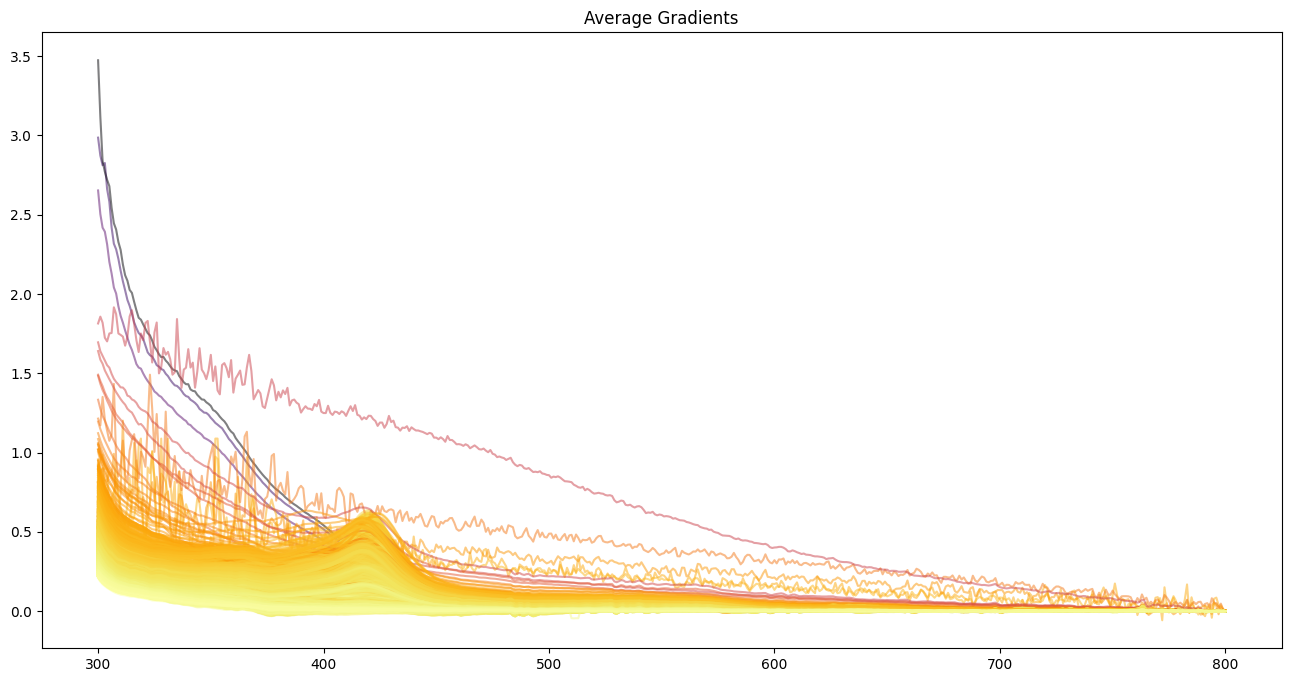

In [154]:
from tqdm.notebook import tqdm

traces = [] 
for path in bad_trace_data['file_path'].unique():
    df = utils.bmg.parse_bmg(path)
    traces.append(df)
    
df = pd.concat(traces).loc[:, 300:]
df = df.subtract(df.loc[:, 800], axis=0)

gradients = np.gradient(df, axis=1).mean(axis=1)
gradients_scaled = gradients - min(gradients)
gradients_scaled /= max(gradients_scaled)

colors = inferno(gradients_scaled)

plt.figure(figsize=(16,8))

for i in tqdm(range(len(df))):
    row = df.iloc[i, :]
    plt.plot(row, 
             c=colors[i],
             alpha=0.5,
            )
plt.title('Average Gradients')
plt.show()

  0%|          | 0/5136 [00:00<?, ?it/s]

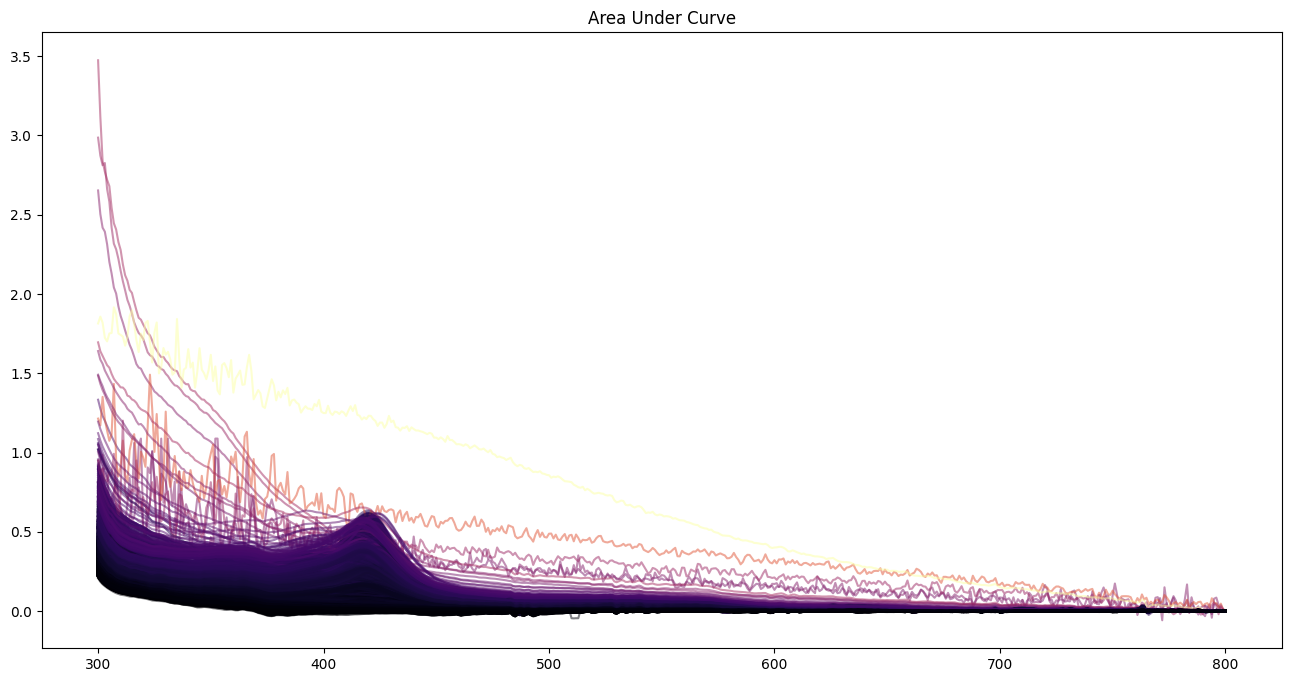

In [155]:
area = np.trapz(df, axis=1)
area_scaled = area - min(area)
area_scaled /= max(area_scaled)

colors = inferno(area_scaled)

plt.figure(figsize=(16,8))

for i in tqdm(range(len(df))):
    row = df.iloc[i, :]
    plt.plot(row, 
             c=colors[i],
             alpha=0.5,
            )
plt.title('Area Under Curve')
plt.show()